
Circuit Simulation Example with OBI-One
======================================

This notebook demonstrates how to run circuit simulations using the obi-one simulation framework
with [BlueCelluLab](https://github.com/openbraininstitute/BlueCelluLab) as the simulator.

In [ ]:
from entitysdk import Client, models
from obi_auth import get_token
import os
import time

from obi_notebook import get_projects
from obi_notebook import get_entities
import obi_one as obi

ENV = "production"
token = get_token(environment=ENV, auth_mode="daf")
project_context = get_projects.get_projects(token)
client = Client(environment=ENV, project_context=project_context, token_manager=token)

### Load pre-downloaded example microcircuit

We'll use a small two-neuron SSCx microcircuit already available in:
`examples/data/tiny_circuits/nbS1-O1-E2Sst-maxNsyn-HEX0-L5`

In [2]:
circuit_folder = "./../data/tiny_circuits/nbS1-O1-E2Sst-maxNsyn-HEX0-L5/"
circuit_name = "test"

If you wouldd prefer to download a different circuit from the platform, see the optional cell below.

In [3]:
# OPTIONAL: Download a circuit from the platform using an ID or UI selection
client = Client(environment=ENV, project_context=project_context, token_manager=token)

# Optional: Download using unique ID
entity_ID = "f27df71c-c59b-4b6d-979e-b2d133926117"  # <<< FILL IN UNIQUE CIRCUIT ID HERE


if entity_ID != "<CIRCUIT-ID>":
    circuit_ids = [entity_ID]
else:
# Alternative: Select from a table of entities
    circuit_ids = []
    circuit_ids = get_entities.get_entities("circuit", token, circuit_ids,
                                            project_context=project_context,
                                            multi_select=False,
                                            default_scale="small")

# Fetch circuit
fetched = client.get_entity(entity_id=circuit_ids[0], entity_type=models.Circuit)
print(f"Circuit fetched: {fetched.name} (ID {fetched.id})\n")
print(f"#Neurons: {fetched.number_neurons}, #Synapses: {fetched.number_synapses}, #Connections: {fetched.number_connections}\n")
print(f"{fetched.description}\n")

# Download SONATA circuit files
asset = [asset for asset in fetched.assets if asset.label=="sonata_circuit"][0]
asset_dir = asset.path
circuit_dir = "analysis_circuit"
assert not os.path.exists(asset_dir), f"ERROR: Circuit download folder '{asset_dir}' already exists! Please delete folder."
assert not os.path.exists(circuit_dir), f"ERROR: Circuit folder '{circuit_dir}' already exists! Delete folder or choose a different path."

t0 = time.time()
client.download_directory(
    entity_id=fetched.id,
    entity_type=models.Circuit,
    asset_id=asset.id,
    output_path="./../data/tiny_circuits/",
    max_concurrent=4,  # Parallel file download
)
t = time.time() - t0
print(f"Circuit files downloaded to '{asset_dir}' in {t:.1f}s")

circuit_folder = "./../data/tiny_circuits/sonata_circuit/"

In [4]:
circ_path = f"{circuit_folder}/circuit_config.json"
circuit = obi.Circuit(name=circuit_name, path=circ_path)
print(f"Circuit '{circuit}' with {circuit.sonata_circuit.nodes.size} neurons and {circuit.sonata_circuit.edges.size} synapses")
print(f"Default node population: '{circuit.default_population_name}'")

Circuit 'test' with 1432 neurons and 7672 synapses
Default node population: 'S1nonbarrel_neurons'


### (Optional) Define and modify node sets in the circuit
Below we show how to modify the node_sets.json file:
- Add new node sets using tags
- Combine or update existing sets

Finally, the modified node sets are saved to a new node_sets.json file.

In [ ]:
# Get SONATA circuit object
c = circuit.sonata_circuit
print("..." + str(c.node_sets.content)[-25:])

# Adding a node set to the circuit
obi.NeuronSet.add_node_set_to_circuit(c, {"Layer23": {"layer": [2, 3]}})
print("..." + str(c.node_sets.content)[-55:])

# Adding a node set with an exising name => NOT POSSIBLE
# obi.NeuronSet.add_node_set_to_circuit(c, {"Layer23": {"layer": [2, 3]}})  # AssertionError: Node set 'Layer23' already exists!

# Update/overwrite an existing node set
obi.NeuronSet.add_node_set_to_circuit(c, {"Layer23": ["Layer2", "Layer3"]}, overwrite_if_exists=True)  # Update/overwrite
print("..." + str(c.node_sets.content)[-58:])

# Adding multiple node sets
obi.NeuronSet.add_node_set_to_circuit(c, {"Layer45": ["Layer4", "Layer5"], "Layer56": ["Layer5", "Layer6"]})
print("..." + str(c.node_sets.content)[-124:])

# Add node set from NeuronSet object, resolved in circuit's default node population
neuron_set = obi.CombinedNeuronSet(node_sets=("Layer1", "Layer2", "Layer3"))
obi.NeuronSet.add_node_set_to_circuit(c, {"Layer123": neuron_set.get_node_set_definition(circuit, circuit.default_population_name)})
print("..." + str(c.node_sets.content)[-168:])

# Adding a node sets based on previously added node sets
obi.NeuronSet.add_node_set_to_circuit(c, {"AllLayers": ["Layer123", "Layer4", "Layer56"]})
print("..." + str(c.node_sets.content)[-216:])

# Write new circuit's node set file
obi.NeuronSet.write_circuit_node_set_file(c, output_path="./", file_name="new_node_sets.json", overwrite_if_exists=True)

Now, let's generate the Simulation Config

In [6]:
from pathlib import Path
import obi_one as obi

# === Parameters ===
output_path = Path(".")
sim_duration = 3000.0

# === 1. Build Form (SimulationsForm) ===
sim_form = obi.SimulationsForm.empty_config()

# Info
info = obi.Info(
    campaign_name="Small Microcircuit Simulation",
    campaign_description="Simulation of circuit with predefined neuron set and constant current stimulus"
)
sim_form.set(info, name="info")

# Neuron Sets
sim_nset = obi.IDNeuronSet(neuron_ids=obi.NamedTuple(name="IDNeuronSet1", elements=range(2)))
sim_form.add(sim_nset, name="ID1")

# Timestamps
timestamps = obi.RegularTimestamps(start_time=0.0, number_of_repetitions=1, interval=100)
sim_form.add(timestamps, name="Timestamps")

# Stimulus
stimulus = obi.PoissonSpikeStimulus(
    duration=800.0,
    timestamps=timestamps.ref,
    frequency=20,
    source_neuron_set=sim_nset.ref,
    targeted_neuron_set=sim_nset.ref
)
sim_form.add(stimulus, name="PoissonInput")

stimulus = obi.ConstantCurrentClampSomaticStimulus(
    timestamps=timestamps.ref, duration=2000.0, neuron_set=sim_nset.ref, amplitude=0.5
)
sim_form.add(stimulus, name="CurrentClampInput")

# Recording
recording = obi.SomaVoltageRecording(neuron_set=sim_nset.ref)
sim_form.add(recording, name="SomaVoltage")

# Initialization block
init = obi.SimulationsForm.Initialize(
    circuit=obi.Circuit(name=circuit_name, path=circ_path),
    node_set=sim_nset.ref,
    simulation_length=sim_duration,
)
sim_form.set(init, name="initialize")

# === 2. Wrap into a Simulation ===
simulation = obi.Simulation(**sim_form.model_dump())
simulation.coordinate_output_root = output_path

# === 3. Generate simulation_config.json + node_sets.json ===
simulation.generate(db_client=client)

In [7]:
population_name = circuit.default_population_name
simulation_config_path = output_path / "simulation_config.json"

Get the path to the mod files and compile the mod files. 

In [ ]:
# Remove the old compiled mod files folder
! rm -r arm64/
# flag DISABLE_REPORTINGLIB to skip SonataReportHelper.mod and SonataReport.mod from compilation.
!../../.venv/bin/nrnivmodl -incflags "-DDISABLE_REPORTINGLIB" {circuit_folder}/mod

Run circuit simulation using BlueCelluLab backend. In future, we will support Neurodamus backend as well. This will run a SONATA simulation.  

In [ ]:
# Run the simulation
from obi_one.scientific.simulation import execution
obi.scientific.simulation.execution.run(
# obi.scientific.simulation.execution.run(
    simulation_config=simulation_config_path,
    simulator="bluecellulab", # Optional: bluecellulab or neurodamus. Default: bluecellulab
    save_nwb=False            # Optional: Save results in NWB format. Default: False
)

The results are stored in the `output` directory. The logs are also stored in the `logs` in notebooks folder.

### Spike Report Analysis using BluePySnap

We will use the example [notebook](https://github.com/openbraininstitute/snap/blob/master/doc/source/notebooks/06_spike_reports.ipynb) from BluePySnap to analyse the spike report generated by the circuit simulation.

In [10]:
import bluepysnap

snap_simulation = bluepysnap.Simulation(simulation_config_path)
spikes = snap_simulation.spikes
print(
    spikes.time_start,
    spikes.time_stop,
    spikes.dt
)
print(spikes.population_names)

0 3000.0 0.025
['S1nonbarrel_neurons']


In [11]:
spike_pop = spikes[population_name]
node_population = spike_pop.nodes

In [12]:
filtered = spikes.filter(group={'layer':'5'}, t_start=spikes.time_start, t_stop=spikes.time_stop)
filtered.report.head()

/Users/ilkankilic/Workspace/snap/bluepysnap/simulation.py:55: RuntimeWarning: Simulation node sets overwrite 147 node set(s) in Circuit node sets: dSTUT, L4_BTC, cACint, L23_LBC, L23_BP, L4_NGC, L6_HPC, nbS1-HEX3-L23, bNAC, hex5, ...
  warnings.warn(


,ids,population
times,,
1.000000e-10,0,S1nonbarrel_neurons
1.000000e-10,1,S1nonbarrel_neurons
1.440000e+01,1,S1nonbarrel_neurons
2.030000e+01,0,S1nonbarrel_neurons
2.525000e+01,1,S1nonbarrel_neurons


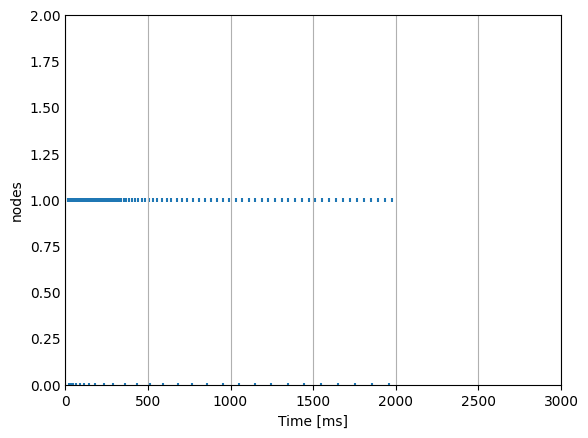

In [13]:
filtered.raster();

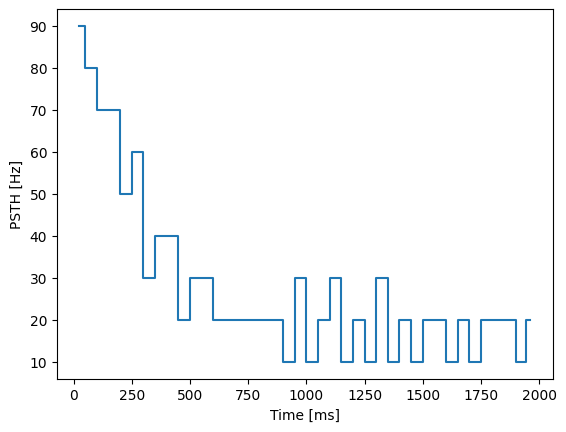

In [14]:
filtered.firing_rate_histogram();

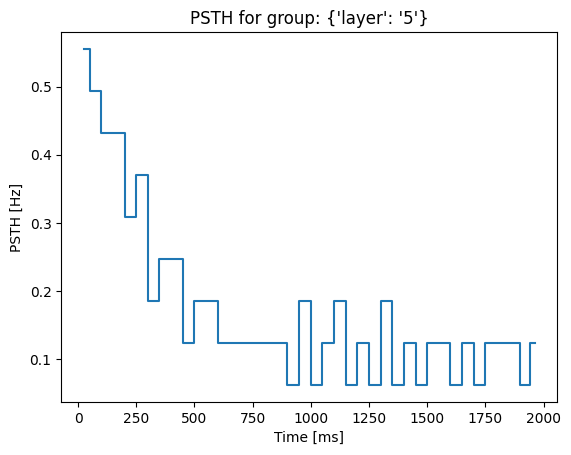

In [15]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()
ax.set_xlabel("Time [ms]")
ax.set_ylabel("PSTH [Hz]")
ax.set_title(f"PSTH for group: {filtered.group}")

times = filtered.report.index

time_start = np.min(times)
time_stop = np.max(times)

# heuristic for a nice bin size (~100 spikes per bin on average)
time_binsize = min(50.0, (time_stop - time_start) / ((len(times) / 100.0) + 1.0))

bins = np.append(np.arange(time_start, time_stop, time_binsize), time_stop)
hist, bin_edges = np.histogram(times, bins=bins)
node_count = len(snap_simulation.circuit.nodes.ids(filtered.group))  # Get length of node ids for whole `group`
freq = 1.0 * hist / node_count / (0.001 * time_binsize)

# use the middle of the bins instead of the start of the bin
ax.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), freq, label="PSTH", drawstyle="steps-mid");

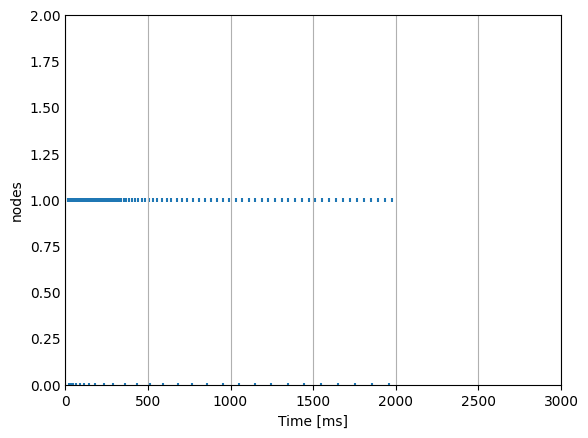

In [16]:
spikes.filter().raster();

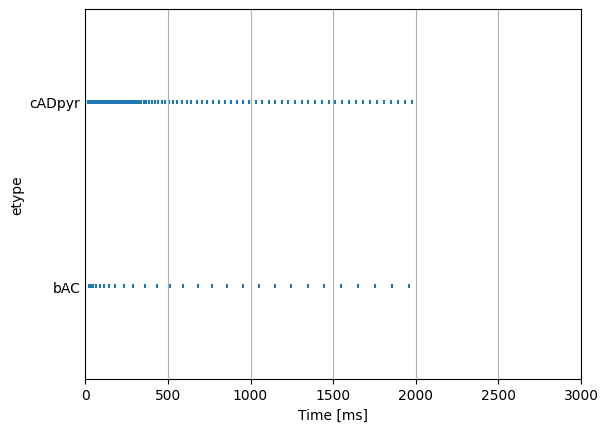

In [17]:
spikes.filter().raster(y_axis='etype');

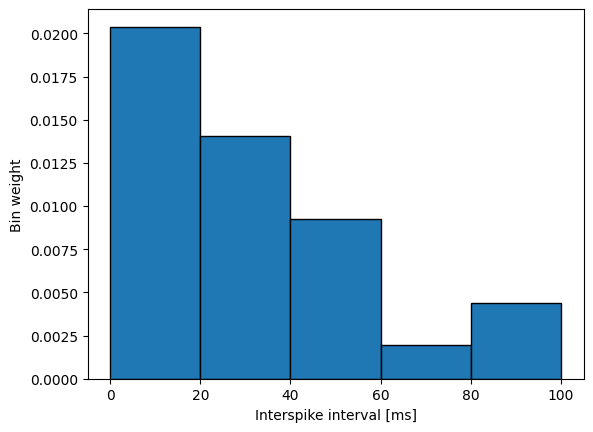

In [18]:
spikes.filter().isi(binsize=20);

### Soma Report Analysis

Let's [load](https://github.com/openbraininstitute/snap/blob/master/doc/source/notebooks/07_frame_reports.ipynb) the soma report using BluePySnap and plot it.

In [19]:
snap_simulation.reports

{'SomaVoltage': <bluepysnap.frame_report.SomaReport at 0x3365dffb0>}

In [20]:
soma_report = snap_simulation.reports['SomaVoltage']

In [21]:
print(
    soma_report.time_start,
    soma_report.time_stop,
    soma_report.dt
)  # Gives a warning in case the dt differs from simulation.dt

2025-08-20 09:43:31,574 - bluepysnap.frame_report - WARNING - dt from the report differs from the global simulation dt.
0.0 3000.0 0.1


In [22]:
soma_report.population_names

['S1nonbarrel_neurons']

In [23]:
soma_pop = soma_report[population_name]

In [24]:
node_population = soma_pop.nodes

In [25]:
ids = soma_pop.node_ids
node_population.get(ids, properties=['layer','synapse_class','x','y','z']).head()

,layer,synapse_class,x,y,z
node_ids,,,,,
0,5,EXC,3927.186219,-1398.412423,-2409.039001
1,5,INH,3821.770721,-1368.835373,-2569.508610


In [26]:
filtered = soma_report.filter(group={'layer':'5'}, t_start= soma_report.time_start, t_stop= soma_report.time_stop)
filtered.report.head()

S1nonbarrel_neurons           
                      0          1
0.0            0.025000   0.025000
0.1          -50.884109 -71.880211
0.2          -61.806530 -79.772331
0.3          -67.277565 -82.037476
0.4          -70.359154 -83.002258